# Normal Distributions

In [1]:
!apt install libomp-dev
!pip install faiss
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pandas as pd
import os
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import torch.distributed as dist
import torch.nn as nn
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import faiss
import pdb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

Density of univariate normal distributions $N(\mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}\exp(-\frac{(x - \mu)^2}{2\sigma^2} )$.

Text(0.5, 1.0, 'Normal Distributions')

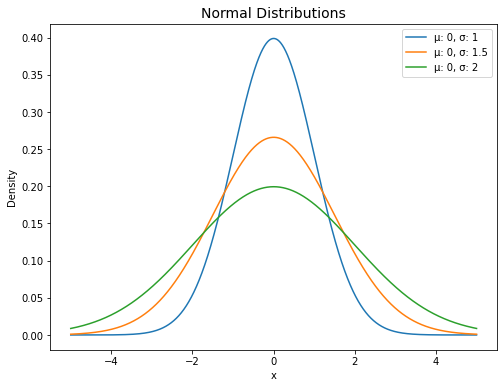

In [ ]:
x = np.arange(-5, 5, 0.001)

plt.figure(figsize=(8, 6))
#define multiple normal distributions
plt.plot(x, norm.pdf(x, 0, 1), label='μ: 0, σ: 1')
plt.plot(x, norm.pdf(x, 0, 1.5), label='μ: 0, σ: 1.5')
plt.plot(x, norm.pdf(x, 0, 2), label='μ: 0, σ: 2')

#add legend to plot
plt.legend()

#add axes labels and a title
plt.ylabel('Density')
plt.xlabel('x')
plt.title('Normal Distributions', fontsize=14)

Density of a bivariate normal distribution: 
$$
  N_2(\left[\begin{array}{c} 0 \\ 0 \end{array}\right], \left[\begin{array}{cc} 1 & 1.5 \\ 1.5 & 4 \end{array}\right]).
$$

(200, 100)

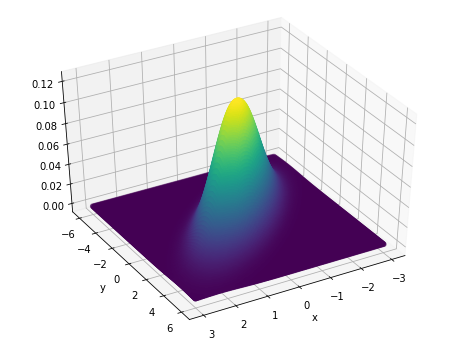

In [ ]:
x = np.linspace(-3*1, 3*1, num=100)
y = np.linspace(-3*2, 3*2, num=200)
X, Y = np.meshgrid(x, y, indexing='xy') 
covM = np.array([[1, 1.5], [1.5, 4]])
distMVN = multivariate_normal(cov=covM)
Z = distMVN.pdf(np.dstack((X, Y)))
plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.scatter3D(X, Y, Z, c = Z, cmap = 'viridis')
ax.view_init(40, 60)
plt.xlabel("x")
plt.ylabel("y")
Z.shape

Conditional distribution of $y$ given $x = 1$.

Text(0.5, 0, 'y')

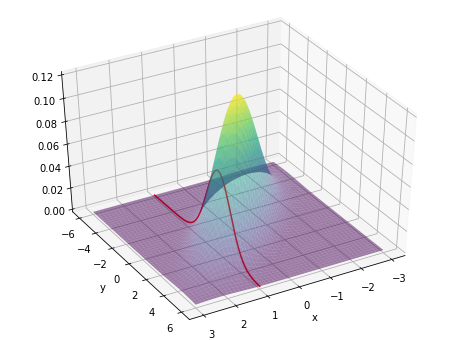

In [ ]:
xCon = np.array([1])
XCon, YCon = np.meshgrid(xCon, y)
ZCon = distMVN.pdf(np.dstack((XCon, YCon)))
plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.plot3D(XCon, YCon, ZCon, 'red')
ax.plot_surface(X, Y, Z, cmap = 'viridis', alpha = 0.5)
ax.view_init(40, 60)
plt.xlabel("x")
plt.ylabel("y")

Extract the curve above and scale it by the inverse of the marginal density of $X$ at $x = 1$. We get the conditional density of $Y \mid X = 1$.

Text(0, 0.5, 'z')

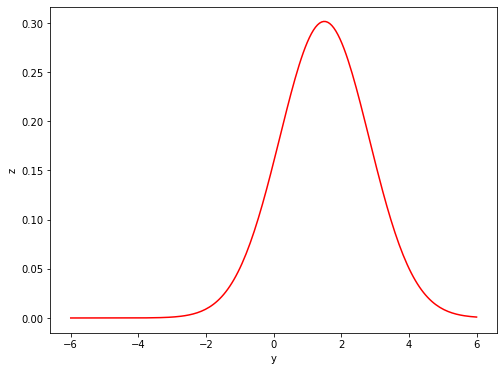

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(YCon, ZCon / norm.pdf(xCon, 0, 1), color = 'red')
plt.xlabel("y")
plt.ylabel("z")

Notice that the above distribution is still a normal distribution.

# Maximum Likelihood Estimation

## Independent and identically distributed (i.i.d.) samples

Read the height-weight dataset.

In [ ]:
dataURL = "https://raw.githubusercontent.com/JCatwood/GPRTutorial/main/data/" \
           "weight-height.csv"
df = pd.read_csv(dataURL)
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Extract the information corresponding to males so that the homogeneity of dataset is stronger.

In [ ]:
df = df[df['Gender'] == 'Male']
df.shape

(5000, 3)

Let's see the distribution (histogram) of the heights.

Text(0.5, 0, 'height')

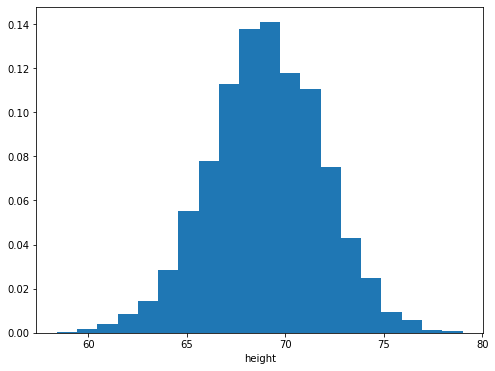

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['Height'], bins=20, density=True)
plt.xlabel("height")

Which curve best fits the data?

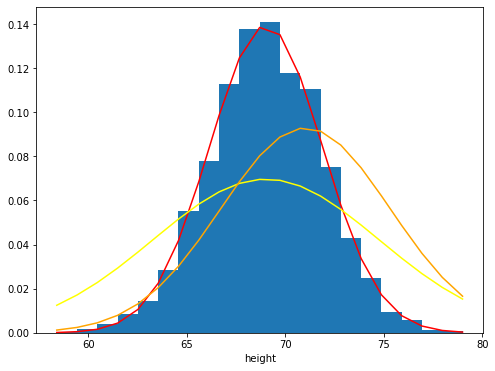

In [ ]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist(df['Height'], bins=20, density=True)
plt.xlabel("height")
avgHt = df['Height'].mean()
sdHt = df['Height'].std()
plt.plot(bins, norm.pdf(bins, loc=avgHt, scale=sdHt), color="red")
plt.plot(bins, norm.pdf(bins, loc=avgHt, scale=sdHt * 2), color="yellow")
plt.plot(bins, norm.pdf(bins, loc=avgHt + 2, scale=sdHt * 1.5), color="orange")

The red curve above would be the optimal model if we assume i.i.d. normal distribution for the heights. Since the maximum of the likelihood of the univariate normal distribution is analytically solvable, we do not need optimization to find the optimal values for the mean and variance parameters.

## Multivariate normal distribution based in $\mathbb{R}^1$

In the previous analysis, we view the heights as i.i.d. random variables, where the prediction for a new person's height is simply the estimated mean parameter. Here, we predict the person's height with his/her weight, for which we fit a Gaussian process, which is a non-parametric model, using the $n$ weight-height pairs.

First, we prepare the $x$-$y$ pairs, notice that $x$ needs to be converted into 2D tensor to use `cdist`.

In [ ]:
x = torch.tensor(df['Weight'])
x = x[0 : 1000, None]
y = torch.tensor(df['Height'])
y = y[0 : 1000]

Next, initialize parameters for the Gaussian process defined over $\mathbb{R}^1$.

In [ ]:
logbeta = torch.tensor([1.0], requires_grad=True)
logsigma = torch.tensor([1.0], requires_grad=True)
lognugget = torch.tensor([0.1], requires_grad=True)
mu = torch.tensor([0.0], requires_grad=True)

Finally, define the negative log-likelihood function using the squared exponential kernel.

In [ ]:
def neg_GP_sqexp(X, y, mu, logsigma, logbeta, lognugget):
  muVec = torch.mul(mu, torch.ones(y.shape))
  distM = torch.cdist(X, X, 2)
  distM = torch.square(torch.div(distM, torch.exp(logbeta)))
  covM = torch.mul(torch.square(torch.exp(logsigma)), \
                   torch.exp(torch.neg(distM)))
  covM = torch.add(covM, torch.mul(torch.eye(covM.shape[0]),\
                                   torch.exp(lognugget)))
  return torch.neg(MultivariateNormal(muVec, covM).log_prob(y))

Set hyper-parameters for optimization. Notice that mini-batching is not used here.

In [ ]:
learning_rate = 1e-2
epochs = 500
optimizer = torch.optim.Adam([mu, logsigma, logbeta, lognugget], \
                            lr=learning_rate)

Training loop.

In [ ]:
for i in range(0, epochs):
  loss = neg_GP_sqexp(x, y, mu, logsigma, logbeta, lognugget)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i%10 == 0:
    print(f"Loglikelihood {torch.neg(loss)} mu {mu} sigma {torch.exp(logsigma)}" \
          f" beta {torch.exp(logbeta)} nugget {torch.exp(lognugget)}\n")

## Plot the posterior distribution

\begin{align*}
  \left( 
  \begin{array}{c} 
    X_1 \\ X_2
  \end{array}
  \right) &\sim N(\left(
  \begin{array}{c} 
    \mu_1 \\ \mu_2
  \end{array}
  \right), \left(
  \begin{array}{cc} 
    \Sigma_{11} & \Sigma_{12}\\ \Sigma_{21} & \Sigma_{22}
  \end{array}
  \right)) \\
  X_2 \mid X_1 &\sim N(\mu_2 + \Sigma_{21} \Sigma_{11}^{-1}(X_1 - \mu_1), \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12})
\end{align*}


A function for computing the posterior mean and variance at given `x` based on the observed `x0` and `y0`.

In [ ]:
def post_infer(x, x0, y0, mu, logsigma, logbeta, lognugget):
  covM00 = torch.cdist(x0, x0, 2)
  covM00 = torch.square(torch.div(covM00, torch.exp(logbeta)))
  covM00 = torch.mul(torch.square(torch.exp(logsigma)), \
                    torch.exp(torch.neg(covM00)))
  covM00 = torch.add(covM00, torch.mul(torch.eye(covM00.shape[0]),\
                                    torch.exp(lognugget)))
  cholM00 = torch.cholesky(covM00)
  covMInv00 = torch.cholesky_inverse(cholM00)

  covM10 = torch.cdist(x, x0, 2)
  covM10 = torch.square(torch.div(covM10, torch.exp(logbeta)))
  covM10 = torch.mul(torch.square(torch.exp(logsigma)), \
                    torch.exp(torch.neg(covM10)))
  
  covM11 = torch.cdist(x, x, 2)
  covM11 = torch.square(torch.div(covM11, torch.exp(logbeta)))
  covM11 = torch.mul(torch.square(torch.exp(logsigma)), \
                    torch.exp(torch.neg(covM11)))

  tmpM = torch.mm(covM10, covMInv00)
  tmpV = torch.sub(y0, torch.mul(mu, torch.ones(y0.shape)))

  muPost = torch.add(torch.mul(mu, torch.ones(x.shape[0])), \
                     torch.squeeze(torch.mm(tmpM, tmpV[:, None])))
  #covM11Post = torch.sub(covM11, torch.mm(tmpM, torch.t(covM10)))
  sigmaPost = torch.sqrt(torch.sub(torch.mul(torch.square(torch.exp(logsigma)),\
                                             torch.ones(x.shape[0])), \
                                   torch.sum(torch.mul(tmpM, covM10), 1)))
  return muPost, sigmaPost

Create a weight vector ranging from the minimum to the maximum of our in-sample data, where we compute the posterior mean and variance.

In [ ]:
weightVec = torch.linspace(x.min(), x.max(), steps=257, 
                           dtype=y.dtype)
weightVec = weightVec[:, None]
with torch.no_grad():
  muPost, sigmaPost = post_infer(weightVec, x, y, mu, logsigma,\
                                 logbeta, lognugget)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)
  


Plot the posterior mean, the confidence interval (i.e., two times the posterior standard deviation), and the in-sample data.

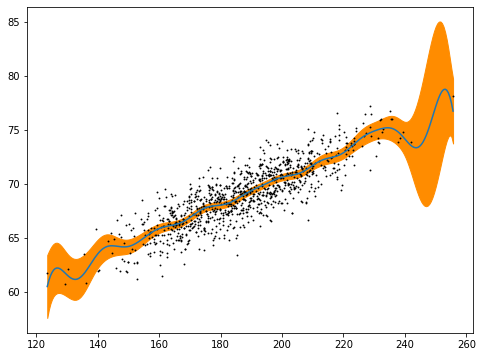

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(torch.squeeze(weightVec), muPost)
plt.fill_between(torch.squeeze(weightVec), muPost - torch.mul(sigmaPost, 2), 
                 muPost + torch.mul(sigmaPost, 2), color='darkorange')
plt.scatter(x, y, s=0.75, color='black')

# Vecchia Approximation

In [11]:
class VecchiaSqexpMeanzeroLoglik(nn.Module):
  def __init__(self, covparms, y, locs):
    super(VecchiaSqexpMeanzeroLoglik, self).__init__()
    self.logsigma = nn.Parameter(covparms[0], requires_grad=True)
    self.logbeta = nn.Parameter(covparms[1], requires_grad=True)
    self.lognugget = nn.Parameter(covparms[2], requires_grad=True)
    self.y = y
    self.locs = locs
  def forward(self, NNarray):
    n, _ = NNarray.shape
    nll = torch.tensor(0.0)
    for i in range(n):
      idxLoc = NNarray[i, :]
      idxLoc[[0, -1]] = idxLoc[[-1, 0]] # so that idx i is at the end
      m = idxLoc.shape[0] - 1
      covM = torch.cdist(self.locs[idxLoc, :], self.locs[idxLoc, :], 2)
      covM = torch.square(torch.div(covM, torch.exp(self.logbeta)))
      covM = torch.mul(torch.square(torch.exp(self.logsigma)), \
                        torch.exp(torch.neg(covM)))
      covM = torch.add(covM, torch.mul(torch.eye(covM.shape[0]),\
                                    torch.exp(self.lognugget)))
      yCi = self.y[idxLoc[:m], None]
      yi = self.y[idxLoc[m]]
      cholM = torch.cholesky(covM)
      yCi, _ = torch.triangular_solve(yCi, cholM[:m, :m], upper=False)
      muPost = torch.mm(cholM[m:(m+1), :m], yCi).squeeze()
      sdPost = cholM[m, m]

      conDist = Normal(muPost, sdPost)
      nll = nll - conDist.log_prob(yi)
    return nll

In [12]:
n = 2000
m = 50
d = 3
locs = torch.rand(n, d)
logbeta = torch.log(torch.tensor(0.5))
logsigma = torch.log(torch.tensor(1.0))
lognugget = torch.log(torch.tensor(0.01))
covM = torch.cdist(locs, locs)
covM = torch.div(covM, torch.exp(logbeta))
covM = torch.exp(torch.neg(torch.square(covM)))
covM = torch.mul(covM, torch.square(torch.exp(logsigma)))
covM = torch.add(covM, torch.mul(torch.eye(n), torch.exp(lognugget)))
GPObj = MultivariateNormal(torch.zeros(n), covM)

In [13]:
y = GPObj.sample()
y = y.sub(y.mean())

In [8]:
VeccObj = VecchiaSqexpMeanzeroLoglik(torch.tensor([0.0, 0, 0]), y, locs)
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, 1024)
locsNP = locs.numpy()
index.train(locsNP)
index.add(locsNP)
index.nprobe = 256
_, NNObj = index.search(locsNP, m + 1)
NNObj = torch.from_numpy(NNObj)

In [ ]:
nIter = 300
optObj = torch.optim.Adam(VeccObj.parameters(), lr=1e-2)
for i in range(nIter):
  loss = VeccObj(NNObj)
  optObj.zero_grad()
  loss.backward()
  optObj.step()
  if i%10 == 9:
    print("i = ", i, "\n")
    for name, parm in VeccObj.named_parameters():
      print(name, ": ", parm.data)
    print("\n")

In [ ]:
torch.exp(VeccObj.lognugget)

tensor(0.0562, grad_fn=<ExpBackward0>)

# Vecchia with Distributed Data Parallel

In [14]:
def Vecchia_DDP_trn(rank, world, y, locs, m):
  os.environ['MASTER_ADDR'] = 'localhost'
  os.environ['MASTER_PORT'] = '12355'
  dist.init_process_group("gloo", rank=rank, world_size=world)

  print(f"Process {rank} in progress\n")

  n, d = locs.shape
  bsz = round(n / world)
  locsNP = locs.numpy()
  index = faiss.IndexFlatL2(d)
  index.add(locsNP)
  _, NNObj = index.search(locsNP, m + 1)
  NNObj = torch.from_numpy(NNObj[rank*bsz : (rank+1)*bsz, :]).to(rank)
  model = VecchiaSqexpMeanzeroLoglik(torch.tensor([.0, .0, .0]), y, 
                                     locs).to(rank)
  modelDDP = DDP(model, device_ids=[rank])
  optObj = torch.optim.Adam(modelDDP.parameters(), lr=1e-2)
  for i in range(300):
    optObj.zero_grad()
    loss = modelDDP(NNObj)
    loss.backward()
    optObj.step()
    if i%19 == 0 and rank == 0:
      print("i = ", i, "\n")
      for name, parm in modelDDP.named_parameters():
        print(name, ": ", parm.data)
      print("\n")

  if rank == 0:
    torch.save(modelDDP.state_dict(), "model.checkpoint")
  dist.destroy_process_group()

In [15]:
world = 2
mp.spawn(Vecchia_DDP_trn, args=(world, y, locs, m), nprocs=world, join=True)